<a href="https://colab.research.google.com/github/jdowner212/cs577_addernet/blob/main/AdderNet_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

## Before running:

1. Set `root` (below) to chosen directory

In [3]:
root = os.getcwd() # whatever you want

2. Download CIFAR10 data

In [4]:
import tarfile


!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
data_zip = os.path.join(root,'cifar-10-python.tar.gz')
f = tarfile.open(data_zip)
f.extractall(root) 
f.close()
os.remove(data_zip)

--2022-11-16 03:22:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  85.9MB/s    in 1.9s    

2022-11-16 03:22:04 (85.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
import numpy as np
import tensorflow as tf
#import tensorflow.keras.backend as K
from tensorflow.python.ops.numpy_ops import np_config
import pickle
import tensorflow.keras.utils as np_utils
np_config.enable_numpy_behavior()
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [6]:
# def L1(a,b):
#     return np.abs(a-b)

def hard_tanh(array):
    array = np.where(array<-1,-1,array)
    array = np.where(array>1, 1, array)
    return array

def eps():
    return np.random.uniform(1e-07,1e-06)


# Layer definitions

### `Layer` parent class

In [7]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, X):
        raise NotImplementedError

    def backward(self, upstream_g, learning_rate):
        raise NotImplementedError

### `Adder` layer

In [30]:
# def adder_single_step(window, filter_, similarity_f=L1):
#     """
#     window -- k_h x k_w x k_d
#     filter -- k_h x k_w x k_d
#     b      -- 1x1x1
#     Z      -- scalar
#     """
#     #H_k,W_k,D_k = filter_.shape
#     #out=0
#     #for h in range(H_k):
#     #    for w in range(W_k):
#     #        for d in range(D_k):
#     #            out += similarity_f(window[h,w,d], filter_[h,w,d])
#     return np.abs(window-filter_).sum()
#     #return out

class adder_layer(Layer):
    def __init__(self,output_channels,kernel_size=3,stride=1,padding=0,adaptive_eta=0):
        self.output_channels = output_channels
        self.output_channels = output_channels
        self.adaptive_eta=adaptive_eta
        self.kernel_size=kernel_size        
        self.stride = stride
        self.padding = padding
        self.bias = np.zeros((1,1,1,self.output_channels))


    def get_adaptive_lr(self, k, dfilters, eta):
        """    
        k           -- n_tensors 
        dfilters    -- c_out x k_H x k_W x c_in
        eta         -- scalar
        """
        
        norm = np.linalg.norm(dfilters, ord=2, axis=0)
        return (eta * np.sqrt(k)) / (norm+eps())


    def forward(self,X):
        """    
        X       -- n_tensors x H x W x c_in
        filters -- c_out x k_H x k_W x c_in
        b       -- c_out x 1 x 1 x 1
        Z       -- n_tensors x H_new x W_new, c_out
        cache   -- info needed for backward pass
        """
        self.input = X
        self.input_channels = X.shape[-1]
        self.filters = np.random.normal(loc=0,scale=1,size=(self.output_channels, self.kernel_size, self.kernel_size, self.input_channels))

        filters,stride,padding,bias = self.filters, self.stride, self.padding, self.bias
        n_tensors, H,   W,   c_in = X.shape
        c_out,     H_k, W_k, c_in = filters.shape
        n_filters = c_out

        X_padded = np.pad(X, ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        H_new = int((H + 2*padding - H_k)/stride)+1
        W_new = int((W + 2*padding - W_k)/stride)+1

        Z = np.zeros([n_tensors, H_new, W_new, c_out])

        for i in range(n_tensors):           # traverse batch
            this_img = X_padded[i,:,:,:]     # select ith image in batch
            for f in range(n_filters):       # traverse filters
                this_filter = filters[f,:,:,:]
                #this_bias = bias[f,:,:,:]
                for h in range(H_new):       # traverse height
                    for w in range(W_new):   # traverse width
                        
                        v0,v1 = h*stride, h*stride + H_k
                        h0,h1 = w*stride, w*stride + W_k
                        
                        this_window = this_img[v0:v1,h0:h1,:]

                        Z[i, h, w, f] = np.abs(this_window-this_filter).sum()

        assert Z.shape == (n_tensors, H_new, W_new, n_filters)

        self.output = Z
        self.cache = X, filters, bias, stride, padding
        
        return self.output

    def backward(self, upstream_g, learning_rate):
        """
        upstream_g (dL/dZ) -- n_tensors x H_up x W_up x c_up
        cache (values from previous layers) -- (X, W, B, s, p)               
        
        Output:
        dX -- dL/dX, shape n_tensors x H_down x W_down x c_down
        dF -- dL/dW, shape n_filters x k x k x k
        dB -- dL/dB, shape n_filters x 1 x 1 x 1
        """
        
        X, filters, bias, stride, padding = self.cache

        n_tensors, H_down, W_down, c_down = X.shape
        n_filters, H_k,    W_k,    c_down = filters.shape
        n_tensors, H_up,   W_up,   c_up   = upstream_g.shape
        
        dX       = np.zeros_like(X)                           
        dfilters = np.zeros_like(filters)
        #dbias    = np.zeros((n_filters, 1,1,c_down))

        X_padded  = np.pad(X,  ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        dX_padded = np.pad(dX, ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        
        for i in range(n_tensors):                       
            x = X_padded[i]
            dx = dX_padded[i]
            
            for h in range(H_up):                   # traverse height
                for w in range(W_up):               # traverse width
                    for c in range(c_up):           # traverse filters
                        
                        v0,v1 = h,h+H_k
                        h0,h1 = w,w+W_k
                        
                        x_window = x[v0:v1, h0:h1, :]
                        f_window = filters[c,:,:,:]

                        dx_local = hard_tanh(f_window-x_window)
                        df_local = (x_window-f_window)

                        g = upstream_g[i, h, w, c]

                        dx[v0:v1, v0:v1, :] += dx_local * g
                        dfilters[c,:,:,:]   += df_local * g
                        #dbias[c,:,:,:]      += g
                        
            dX[i, :, :, :] = dx[padding:-padding, padding:-padding, :]
        
        assert(dX.shape == (n_tensors, H_down, W_down, c_down))


        adaptive_lr = self.get_adaptive_lr(n_filters, dfilters, self.adaptive_eta)

        self.filters -= learning_rate*adaptive_lr*dfilters
        #self.bias    -= learning_rate*dbias

        return dX


    # def backward(self, upstream_g, learning_rate):
    #     k = self.kernel_size
    #     #window - filter
    #     num  = (self.input - self.filters)*upstream_g.sum()
    #     den = (num.norm(p=2).clamp(min=1e-012)*np.sqrt(k**2)).sum()

    #     dW = ((self.input.unsqueeze(0)-self.filters.unsqueeze(2))*upstream_g.unsqueeze(1)).sum(2)
    #     dW = num/den

    #     dX = sum(-(self.input - self.filters).clamp(-1,1)*upstream_g)
    #     #dW = dW/dW.norm(p=2).clamp(min=1e-12)*np.sqrt(self.filters.shape[1]*self.filters.size(0))/5
    #     #dX = (-(self.input.unsqueeze(0)-self.filters.unsqueeze(2)).clamp(-1,1)*upstream_g.unsqueeze(1)).sum(0)
        

In [31]:
def conv_single_step(window, filter_, bias):
    """
    window -- k_h x k_w x k_d
    filter_ -- k_h x k_w x k_d
    b      -- 1x1x1
    Z      -- scalar
    """
    out = np.sum((np.multiply(window,filter_) + bias.astype(float))).astype(float)
    
    return out

class conv_layer(Layer):
    def __init__(self,output_channels,kernel_size=3,stride=1,padding=0):#,similarity_f = L1):
        self.output_channels = output_channels


        self.output_channels = output_channels
        self.adaptive_eta=0

        self.kernel_size=kernel_size        
        self.stride = stride
        self.padding = padding



    def forward(self,X):
        """    
        X       -- n_tensors x H x W x c_in
        filters -- c_out x k_H x k_W x c_in
        b       -- c_out x 1 x 1 x 1
        Z       -- n_tensors x H_new x W_new, c_out
        cache   -- info needed for backward pass
        """
        self.input = X

        # in case input size not given
        self.input_channels = X.shape[-1]

        self.filters = np.random.normal(loc=0,scale=1,size=(self.output_channels, self.kernel_size, self.kernel_size, self.input_channels))
        self.bias    = np.random.normal(loc=0,scale=1,size=(self.output_channels, 1,1,1))
        
        filters,stride,padding,bias = self.filters, self.stride, self.padding, self.bias
        n_tensors, H,   W,   c_in = X.shape
        c_out,     H_k, W_k, c_in = filters.shape
        n_filters = c_out

        X_padded = np.pad(X, ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        H_new = int((H + 2*padding - H_k)/stride)+1
        W_new = int((W + 2*padding - W_k)/stride)+1

        Z = np.zeros([n_tensors, H_new, W_new, c_out])

        for i in range(n_tensors):           # traverse batch
            this_img = X_padded[i,:,:,:]     # select ith image in batch
            for f in range(n_filters):       # traverse filters
                this_filter = filters[f,:,:,:]
                this_bias   = bias[f,:,:,:]
                for h in range(H_new):       # traverse height
                    for w in range(W_new):   # traverse width
                        
                        v0,v1 = h*stride, h*stride + H_k
                        h0,h1 = w*stride, w*stride + W_k
                        
                        this_window = this_img[v0:v1,h0:h1,:]

                        Z[i, h, w, f] = conv_single_step(this_window, this_filter, this_bias) 

        assert Z.shape == (n_tensors, H_new, W_new, n_filters)

        self.output = Z
        self.cache = X, filters, bias, stride, padding
        
        return self.output

    def backward(self, upstream_g, learning_rate):
        """
        upstream_g (dL/dZ) -- n_tensors x H_up x W_up x c_up
        cache (values from previous layers) -- (X, W, B, s, p)               
        
        Output:
        dX -- dL/dX, shape n_tensors x H_down x W_down x c_down
        dF -- dL/dW, shape n_filters x k x k x k
        dB -- dL/dB, shape n_filters x 1 x 1 x 1
        """
        X, filters, bias, stride, padding = self.cache

        n_tensors, H_down, W_down, c_down = X.shape
        n_filters, H_k,    W_k,    c_down = filters.shape
        n_tensors, H_up,   W_up,   c_up   = upstream_g.shape
        
        dX       = np.zeros_like(X)                           
        dfilters = np.zeros_like(filters)
        dbias    = np.zeros((n_filters, 1,1,1))

        X_padded  = np.pad(X,  ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        dX_padded = np.pad(dX, ((0,0), (padding,padding), (padding,padding), (0,0)), 'constant', constant_values = (0,0))
        
        for i in range(n_tensors):                       
            x = X_padded[i]
            dx = dX_padded[i]
            
            for h in range(H_up):                   # traverse height
                for w in range(W_up):               # traverse width
                    for c in range(c_up):           # traverse filters
                        
                        v0,v1 = h,h+H_k
                        h0,h1 = w,w+W_k
                        
                        x_window = x[v0:v1, h0:h1, :]
                        f_window = filters[c,:,:,:]

                        dx_local = hard_tanh(f_window-x_window)
                        df_local = x_window-f_window

                        g = upstream_g[i, h, w, c]

                        dx[v0:v1, v0:v1, :] += dx_local * g
                        dfilters[c,:,:,:]   += df_local * g
                        dbias[c,:,:,:]      += g
                        
            dX[i, :, :, :] = dx[padding:-padding, padding:-padding, :]
        
        assert(dX.shape == (n_tensors, H_down, W_down, c_down))

        self.filters -= learning_rate*dfilters
        self.bias    -= learning_rate*dbias

        return dX

### Fully-connected layer

In [32]:
class FullyConnected(Layer):
    def __init__(self,output_channels):
        super(Layer, self).__init__()
        self.output_channels = output_channels

    def forward(self, X):
        self.input = X
        self.input_channels = X.shape[-1]
        self.weights = np.random.normal(loc=0,scale=1,size=(self.input_channels,self.output_channels))
        self.bias = np.random.normal(loc=0,scale=1,size=(X.shape[0], self.output_channels))
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward(self, upstream_g, learning_rate):
        dX    = np.dot(upstream_g, self.weights.T)
        dW    = np.dot(self.input.T, upstream_g)
        dbias = upstream_g

        self.weights -= learning_rate*dW
        self.bias    -= learning_rate*dbias

        return dX

### Flatten layer

In [33]:
class Flatten(Layer):
    def forward(self, X):
        self.original_shape = X.shape
        self.output = X.reshape(X.shape[0],np.product(X.shape[1:]))
        return self.output

    def backward(self, upstream_g, learning_rate):
        return upstream_g.reshape(self.original_shape)

### BatchNorm Layer

In [34]:
class batch_norm_layer(Layer):
    def __init__(self, gamma=None,beta=None):

        gamma = None if not gamma else gamma
        self.gamma = gamma
        beta = None if not beta else beta
        self.beta = beta

    def forward(self, X):
        """    
        X       -- n_tensors x H x W x c_in
        gamma   -- n_tensors x 1 x 1 x 1
        beta    -- n_tensors x 1 x 1 x 1
        cache   -- info needed for backward pass
        """

        self.input = X

        self.gamma = np.ones((X.shape[0],1,1,1))
        self.beta = np.zeros((X.shape[0],1,1,1))


        mean = np.mean(X,axis=(0, 1, 2), keepdims=True)
        var = np.mean(((X-mean)**2), axis=(0, 1, 2), keepdims=True)
        std = np.sqrt(var)
        
        X_center = X - mean
        X_norm = X_center/(std+eps())

        self.output = X_norm*self.gamma + self.beta
        self.cache = X, X_center, X_norm

        return self.output 


    def backward(self, upstream_g, learning_rate):
        """
        upstream_g (dL/dZ) -- n_tensors x H_up x W_up x c_up
        cache (values from previous layers) -- (X, X_norm)               
        
        Output:
        dX -- dL/dX, shape n_tensors x H_down x W_down x c_down
        dF -- dL/dW, shape n_filters x k x k x k
        dB -- dL/dB, shape n_filters x 1 x 1 x 1
        """

        X, X_center, X_norm = self.cache

        dGamma = np.sum(upstream_g * X_norm, axis=0)
        dBeta = np.sum(upstream_g, axis=0)

        m = len(X)
        mean = np.mean(X)
        std = np.std(X)
        
        dX = np.zeros_like(X)

        for i in range(m):
            for j in range(m):
                dX[i] += (upstream_g[i] - upstream_g[j]*(1 + (X[i]-X[j])*(X[j]-mean)/std))
        dX *= self.gamma/((m**2)*std)
        
        self.gamma = self.gamma - learning_rate*dGamma
        self.beta  = self.beta  - learning_rate*dBeta

        return dX

### Maxpool layer

In [35]:
class MaxPool(Layer):
    def __init__(self,pool_size=2):
        self.pool_size=pool_size
        self.stride = pool_size

    def forward(self,X):
        n_tensors, H, W, c_in = X.shape

        H_new = int(1 + (H - self.pool_size) / self.stride)
        W_new = int(1 + (W - self.pool_size) / self.stride)
        c_out = c_in
        
        Z = np.zeros((n_tensors, H_new, W_new, c_out))              
        
        for i in range(n_tensors):                     # loop over the training examples
            for h in range(H_new):                     # loop on the vertical axis of the output volume
                for w in range(W_new):                 # loop on the horizontal axis of the output volume
                    for c in range(c_out):             # loop over the channels of the output volume
                        
                        v0,v1 = h*self.stride, h*self.stride + self.pool_size
                        h0,h1 = w*self.stride, w*self.stride + self.pool_size
                        
                        window = X[i, v0:v1, h0:h1,c]
                    
                        Z[i, h, w, c] = np.max(window)

        self.output = Z
        self.cache = X, self.pool_size, self.stride
        
        return self.output

    def backward(self, upstream_g,learning_rate):
        X, pool_size, stride = self.cache

        n_tensors, H_down, W_down, c_down = X.shape
        n_tensors, H_up,   W_up,   c_up   = upstream_g.shape


        dX = np.zeros(X.shape)
        
        for i in range(n_tensors):                       
            x = X[i]
            for h in range(H_up):       
            
                for w in range(W_up):    
                    for c in range(c_up):       
                        v0,v1 = h, h+pool_size
                        h0,h1 = w, w+pool_size

                        x_window = x[v0:v1, h0:h1, c]
                        
                        local_g = np.where(x_window==np.max(x_window),1,0)
                        g       = upstream_g[i, h, w, c]
                         
                        dX[i, v0:v1, h0:h1, c] += local_g * g

        assert(dX.shape == X.shape)
        
        return dX


### Activation layers

In [36]:
def relu_fwd(X):
    return np.where(X>=0,X,0)
def relu_bwd(X):
    return np.where(X>=0,1,0)

def softmax_fwd(x):
    soft = tf.nn.softmax(x)
    return soft.numpy()

def softmax_bwd(X): 
    s = softmax_fwd(X)
    d = np.diag(s)
    J = diags(d, shape=s.shape).toarray()

    for i in range(len(J)):
        for j in range(len(J[i])):
            if i == j:
                J[i][j] = s[i][j] * (1-s[i][j])
            else: 
                J[i][j] = -s[i][j]*s[i][j]
    return J

def sig_fwd(X):
    return 1/(1 + np.exp(-X))
def sig_bwd(X):
    return sig_fwd(X) * (1 - sig_fwd(X))

activation_dict = {'relu':    {'forward':  relu_fwd,
                               'backward': relu_bwd},
                   'softmax': {'forward':  softmax_fwd,
                               'backward': softmax_bwd},
                   'sigmoid': {'forward':  sig_fwd,
                               'backward': sig_bwd}}

class Activation(Layer):
    def __init__(self,activation_name):
        super(Layer, self).__init__()
        self.fwd=activation_dict[activation_name]['forward']
        self.bwd=activation_dict[activation_name]['backward']

    def forward(self, X):
        self.input = X
        self.output = self.fwd(X)
        return self.output

    def backward(self, upstream_g, learning_rate):
        local_g = self.bwd(self.input)
        return local_g*upstream_g

### `Model` class

In [37]:
def cat_cross_entropy(y_true, y_pred):    
    out = -np.mean(y_true*np.log(y_pred+eps()))
    return out

def cat_cross_entropy_prime(y_true,y_pred):
    return np.mean([-y/(yhat+eps()) for (y,yhat) in zip(y_true,y_pred)])


loss_dict = {'cat_cross_entropy':    {'forward':  cat_cross_entropy,
                                      'backward': cat_cross_entropy_prime}}

def get_mini_batches(X,y,batch_size):
    mini_batches = []
    for i in range(0,len(X), batch_size):
        lower = i
        upper = np.min([len(X), i + batch_size])
        X_batch = X[lower:upper]
        y_batch = y[lower:upper]
        mini_batches.append((X_batch,y_batch))

    return mini_batches

class Model:
    def __init__(self,loss_name): 
        self.layers = []
        self.loss_fwd = loss_dict[loss_name]['forward']
        self.loss_bwd = loss_dict[loss_name]['backward']

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, input_data):
        y_hat = []
        Z = input_data
        for layer in self.layers:
            Z = layer.forward(Z)
        y_hat = Z
        return y_hat

    def fit(self, x_train, y_train, epochs, batch_size, learning_rate, x_val=None, y_val=None):
        history = {'accuracy': [],'loss': [],'val_accuracy': [],'val_loss': []}

        for e in range(epochs):
            print(e)

            loss_,acc,val_loss,val_acc=0,0,0,0

            mini_batches = get_mini_batches(x_train,y_train, batch_size)

            for i, mini_batch in enumerate(mini_batches):
                
                print(f'batch: {i+1}/{len(mini_batches)+1}')

                x_batch, y_batch = mini_batch

                # forward
                Z = x_batch
                for layer in self.layers:
                    Z = layer.forward(Z)

                y_real = y_batch
                y_pred = Z

                # compute loss and accuracy
                loss_ += self.loss_fwd(y_real, y_pred)
                acc   += sum(np.where(np.argmax(y_real,axis=1)==np.argmax(y_pred,axis=1),1,0))

                # backward
                error = self.loss_bwd(y_real, y_pred)
                for layer in (self.layers)[::-1]:
                    error = layer.backward(error, learning_rate)
              
            loss_ /= x_train.shape[0]
            acc  /= x_train.shape[0]
            
            history['loss'].append(loss_)
            history['accuracy'].append(acc)

            if x_val is None or y_val is None:
                print(f'Epoch: {e}   loss = {str(round(loss_,3))}   acc = {str(round(acc,3))}')
            else:
                Z_val = x_val
                for layer in self.layers:
                    Z_val = layer.forward(Z_val)

                y_real_val = y_val
                y_pred_val = Z_val

                val_loss = self.loss_fwd(y_real_val, y_pred_val)
                val_acc = sum(np.where(np.argmax(y_real_val,axis=1)==np.argmax(y_pred_val,axis=1),1,0))
                val_acc  /= x_val.shape[0]                

                history['val_accuracy'].append(val_acc)
                history['val_loss'].append(val_loss)

                print(f'Epoch: {e}   loss = {str(round(loss_,3))}   acc = {str(round(acc,3))}   val_loss = {str(round(val_loss,3))}   val_accuracy = {str(round(val_acc,3))}')

        return history


## Data collection

### CIFAR10

In [38]:
def load_cifar_data(folder,tiny=False):
    train_batches = [f'{folder}/{f}' for f in os.listdir(folder) if 'batch_' in f]
    test_batch    =  f'{folder}/test_batch'

    # Get train data
    X_trn = None
    y_trn = []
    for i in range(len(train_batches)):
        train_data_dict = pickle.load(open(train_batches[i],'rb'), encoding='latin-1')
        if i+1 == 1:
            X_trn = train_data_dict['data']
        else:
            X_trn = np.vstack((X_trn, train_data_dict['data']))
        y_trn += train_data_dict['labels']
    X_trn = X_trn.reshape(len(X_trn),3,32,32)
    X_trn = np.rollaxis(X_trn,1,4)
    X_trn = X_trn.astype('float32')/255.0
    y_trn = np_utils.to_categorical(np.asarray(y_trn),10)

    # Get test data
    test_data_dict  = pickle.load(open(test_batch,'rb'), encoding='latin-1')
    X_tst = test_data_dict['data']
    X_tst = X_tst.reshape(len(X_tst),3,32,32)
    X_tst = np.rollaxis(X_tst,1,4)
    X_tst = X_tst.astype('float32')/255.0
    y_tst = np_utils.to_categorical(np.asarray(test_data_dict['labels']))
    
    n_90 = int(0.9*len(X_trn))
    X_trn, X_val = X_trn[:n_90], X_trn[n_90:]
    y_trn, y_val = y_trn[:n_90], y_trn[n_90:]

    if tiny:
        X_trn,y_trn,X_tst,y_tst,X_val,y_val = X_trn[:1000],y_trn[:1000],X_tst[:100],y_tst[:100],X_val[:100],y_val[:100]

    return X_trn, y_trn, X_tst, y_tst, X_val, y_val

data_dir = f'{root}/cifar-10-batches-py'
X_trn_c10, y_trn_c10, X_tst_c10, y_tst_c10, X_val_c10, y_val_c10 = load_cifar_data(data_dir,tiny=True)

In [39]:
this_model = Model(loss_name='cat_cross_entropy')

this_model.add(adder_layer(output_channels=8,kernel_size=3,stride=1,padding=1,adaptive_eta=0.1))
this_model.add(Activation('relu'))
this_model.add(MaxPool(pool_size=2))
this_model.add(batch_norm_layer())

this_model.add(Flatten())

this_model.add(FullyConnected(output_channels=64))
this_model.add(Activation('relu'))
this_model.add(FullyConnected(output_channels=10))
this_model.add(Activation('softmax'))

In [ ]:
history = this_model.fit(X_trn_c10,y_trn_c10,epochs=20,batch_size=64,learning_rate=1e-01,x_val=X_val_c10,y_val=y_val_c10)

0
batch: 1/17
batch: 2/17
batch: 3/17
batch: 4/17
batch: 5/17
batch: 6/17
batch: 7/17
batch: 8/17
batch: 9/17
batch: 10/17
batch: 11/17
batch: 12/17
batch: 13/17
batch: 14/17
batch: 15/17
batch: 16/17
Epoch: 0   loss = 0.021   acc = 0.094   val_loss = 1.286   val_accuracy = 0.17
1
batch: 1/17
batch: 2/17
batch: 3/17
batch: 4/17
batch: 5/17
batch: 6/17
batch: 7/17
batch: 8/17
batch: 9/17
batch: 10/17
batch: 11/17
batch: 12/17
batch: 13/17
batch: 14/17
batch: 15/17
batch: 16/17
Epoch: 1   loss = 0.021   acc = 0.087   val_loss = 1.259   val_accuracy = 0.15
2
batch: 1/17
batch: 2/17
batch: 3/17
batch: 4/17
batch: 5/17
batch: 6/17
batch: 7/17
batch: 8/17
batch: 9/17
batch: 10/17
batch: 11/17
batch: 12/17
batch: 13/17
batch: 14/17
batch: 15/17
batch: 16/17
Epoch: 2   loss = 0.021   acc = 0.097   val_loss = 1.268   val_accuracy = 0.11
3
batch: 1/17
batch: 2/17
batch: 3/17
batch: 4/17
batch: 5/17
batch: 6/17
batch: 7/17
batch: 8/17
batch: 9/17
batch: 10/17
batch: 11/17
batch: 12/17
batch: 13/1

In [1]:
plt.figure(figsize=(8,5))
plt.plot(range(20),history['accuracy'],label='train')
plt.plot(range(20),history['val_accuracy'],label='val')
plt.legend()
plt.xlabel('Epochs')
plt.xticks(range(0,21,2))
plt.ylim(0,0.3)
plt.title('Accuracy -- our AdderNet implementation')
plt.show()

NameError: ignored

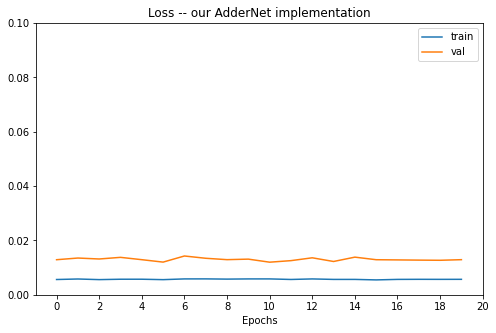

In [55]:
plt.figure(figsize=(8,5))
plt.plot(range(20),history['loss'],label='train')
plt.plot(range(20),history['val_loss'],label='val')
plt.legend()
plt.xlabel('Epochs')
plt.xticks(range(0,21,2))
plt.ylim(0,0.1)
plt.title('Loss -- our AdderNet implementation')
plt.show()



In [112]:
#this_model = Model(loss_name='cat_cross_entropy')
# l1 = X_trn_c10
# l1=adder_layer(output_channels=8,kernel_size=3,stride=1,padding=1).forward(l1)
# print(l1.shape)
# l2=Activation('relu').forward(l1)
# print(l2.shape)
# l3=MaxPool(pool_size=2).forward(l2)
# print(l3.shape)
# l4=batch_norm_layer().forward(l3)
# print(l4.shape)

# l5=Flatten().forward(l4)
# print(l5.shape)
# l6=FullyConnected(output_channels=64).forward(l5)
# print(l6.shape)
# l7=Activation('relu').forward(l6)
# print(l7.shape)
# l8=FullyConnected(output_channels=10).forward(l7)
# print(l8.shape)
# l9=Activation('softmax').forward(l8)
# print(l9.shape)

In [ ]:
cnn = Model(loss_name='cat_cross_entropy')

cnn.add(conv_layer(output_channels=8,kernel_size=3,stride=1,padding=1))
cnn.add(Activation('relu'))
cnn.add(MaxPool(pool_size=2))
cnn.add(batch_norm_layer())


cnn.add(Flatten())

cnn.add(FullyConnected(output_channels=64))
cnn.add(Activation('relu'))
cnn.add(FullyConnected(output_channels=10))
cnn.add(Activation('softmax'))

In [ ]:
cnn.fit(X_trn_c10,y_trn_c10,10,1e-05,X_val_c10,y_val_c10)